# Support Vector Classifier Model on Cough Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
import itertools
import os
import pickle

In [2]:
audio_type = 'cough'
data_path = os.path.join('..', '..', 'data_struc', f'data_{audio_type}')

## Loading datasets

In [4]:
train = pd.read_csv(os.path.join(data_path, 'train.csv'))
test = pd.read_csv(os.path.join(data_path, 'test.csv'))
val = pd.read_csv(os.path.join(data_path, 'valid.csv'))

train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]
val = val.loc[:, ~val.columns.str.contains('^Unnamed')]

train['target'] = train['target'].apply(lambda x: 1 if x == 'covid' else 0)
test['target'] = test['target'].apply(lambda x: 1 if x == 'covid' else 0)
val['target'] = val['target'].apply(lambda x: 1 if x == 'covid' else 0)

train.dropna(inplace=True)
test.dropna(inplace=True)
val.dropna(inplace=True)

# Appending validation to test, as we are using cross-validation anyway.
test = test.append(val, ignore_index=True)

train = shuffle(train, random_state=1)

In [6]:
covid, normal = 0, 0
for idx, row in train.iterrows():
    if(row['target'] == 1):
        covid += 1
    else:
        normal += 1

print(covid)
print(normal)

142
627


In [7]:
X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

X_val = val.drop('target', axis=1)
y_val = val['target']

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Applying PCA

In [8]:
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_
explained_variance = [i * 100 for i in explained_variance]

In [9]:
cumulative_variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4) * 100)

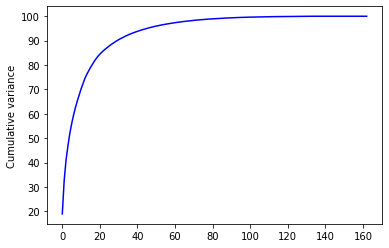

In [10]:
plt.ylabel('Cumulative variance')
plt.plot(cumulative_variance, color='b');

In [11]:
pca = PCA(n_components=20)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

## Training and Making Predictions


In [35]:
# Hyperparameters chosen after repeatedly narrowing the range of values.
param_grid = {
    'C': [5, 6, 7, 8],  
    'gamma': [0.019, 0.02, 0.021]
}

grid = GridSearchCV(
    SVC(probability=True), 
    param_grid, 
    refit = True, 
    cv=10, 
    n_jobs=-1,
    verbose=5
)

grid.fit(X_train, y_train) 

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    6.0s finished


GridSearchCV(cv=10, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [5, 6, 7, 8], 'gamma': [0.019, 0.02, 0.021]},
             verbose=5)

In [36]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

# Printing best cross-validation accuracy -- use this value and NOT test metrics to tune hyperparameters.
print(grid.best_score_)

{'C': 6, 'gamma': 0.02}
SVC(C=6, gamma=0.02, probability=True)
0.942822966507177


[[152   4]
 [  9  27]]
Accuracy:  0.9322916666666666
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       156
           1       0.87      0.75      0.81        36

    accuracy                           0.93       192
   macro avg       0.91      0.86      0.88       192
weighted avg       0.93      0.93      0.93       192



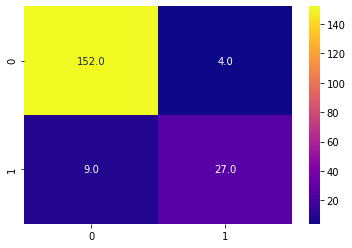

In [37]:
y_pred = grid.predict(X_test) 

cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, cmap = 'plasma', annot = True, fmt = ".1f")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

In [16]:
with open('svc_cough.pickle', 'wb') as f:
    pickle.dump(grid, f)